In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm

In [2]:
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    min_records=60,
    min_volume=1e5,
    start_date="2022-01-01",
    end_date=None
)

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 567 USDT trading pairs
✓ BTCUSDT loaded successfully with 1383 records, avg volume: 14,745,136,253
Loaded 511 cryptocurrencies
Filtered 54 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 510 tickers over 1383 dates...
Precomputed returns matrix shape: (1383, 510)
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00


In [3]:
price = data_loader.get_price_matrix()
price

,1000000BOBUSDT,1000000MOGUSDT,1000BONKUSDT,1000CATUSDT,1000CHEEMSUSDT,1000FLOKIUSDT,1000LUNCUSDT,1000PEPEUSDT,1000RATSUSDT,1000SATSUSDT,...,ZENUSDT,ZEREBROUSDT,ZETAUSDT,ZILUSDT,ZKJUSDT,ZKUSDT,ZORAUSDT,ZRCUSDT,ZROUSDT,ZRXUSDT
2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.926,NaN,NaN,0.07662,NaN,NaN,NaN,NaN,NaN,0.8735
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.096,NaN,NaN,0.07707,NaN,NaN,NaN,NaN,NaN,0.8884
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.473,NaN,NaN,0.07439,NaN,NaN,NaN,NaN,NaN,0.9405
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.440,NaN,NaN,0.07110,NaN,NaN,NaN,NaN,NaN,0.8894
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60.293,NaN,NaN,0.06663,NaN,NaN,NaN,NaN,NaN,0.8260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-10,0.03261,0.4605,0.012937,0.005666,0.001595,0.06686,0.03616,0.006664,0.01311,0.000025,...,11.467,0.01130,0.1126,0.00759,0.0838,0.03982,0.08973,0.01504,1.7935,0.1866
2025-10-11,0.03029,0.4436,0.013502,0.005567,0.001496,0.06651,0.03692,0.006720,0.01386,0.000024,...,13.124,0.04118,0.1121,0.00760,0.0783,0.04042,0.07744,0.01485,1.7271,0.1925
2025-10-12,0.03454,0.5235,0.015439,0.006559,0.001602,0.07391,0.04177,0.007482,0.02647,0.000028,...,14.079,0.03221,0.1217,0.00836,0.0891,0.04062,0.09157,0.01607,1.9550,0.2126
2025-10-13,0.03567,0.5328,0.016720,0.006589,0.001615,0.07787,0.04353,0.007838,0.02838,0.000029,...,13.497,0.04441,0.1306,0.00885,0.0964,0.04236,0.09314,0.01635,2.0355,0.2306


In [4]:
# Composite momentum: build list of non-overlapping (or simple) block returns
# This cell intentionally only computes `rets_list` (block returns) and the warm-up `n`
# The previous rank->normal scoring path was removed to avoid leaving obsolete code behind.
momentum_periods = [14]
momentum_weights = None
non_overlapping = False

# Validate inputs
if not isinstance(momentum_periods, (list, tuple, np.ndarray)):
    momentum_periods = [int(momentum_periods)]
momentum_periods = [int(p) for p in momentum_periods if p > 0]
if len(momentum_periods) == 0:
    raise ValueError("momentum_periods must contain at least one positive integer")

if momentum_weights is not None:
    if len(momentum_weights) != len(momentum_periods):
        raise ValueError("momentum_weights must be the same length as momentum_periods")
    momentum_weights = np.array(momentum_weights, dtype=float)
    if momentum_weights.sum() == 0:
        raise ValueError("momentum_weights must not sum to zero")
    momentum_weights = momentum_weights / momentum_weights.sum()

# Build list of momentum series (block returns)
rets_list = []
if non_overlapping:
    # Interpret `momentum_periods` as cumulative endpoints (days back from t).
    periods = sorted(int(p) for p in momentum_periods)
    if any(p <= 0 for p in periods):
        raise ValueError("momentum_periods must contain positive integers")
    chunk_lengths = [periods[0]] + [periods[i] - periods[i-1] for i in range(1, len(periods))]

    end_shift = 1
    for p in chunk_lengths:
        # For a block of length `p`, we want the return covering the p periods
        # immediately prior to the most recent available price (t-1..t-p).
        # Using shifted prices, this corresponds to: price.shift(end_shift) / price.shift(end_shift + p) - 1
        start_shift = end_shift + p
        # lookahead-safe block return: return over the p days ending at t-1
        rets_chunk = price.shift(end_shift).div(price.shift(start_shift)).subtract(1)
        rets_list.append(rets_chunk)
        end_shift += p
else:
    # overlapping/simple interpretation: standard pct_change over each period
    rets_list = [price.shift(1).pct_change(p) for p in momentum_periods]

# Set warm-up n to total lookback required (largest cumulative endpoint + 1 for non-overlap)
if non_overlapping:
    n = max(periods) + 1
else:
    n = max(momentum_periods)

# `rets_list` is available for downstream cells (simple average or EWMA branch will consume it)
len(rets_list)

C:\Users\USER\AppData\Local\Temp\ipykernel_11252\4086849708.py:44: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets_list = [price.shift(1).pct_change(p) for p in momentum_periods]


1

In [5]:
# Adjustable parameters for quantile selection
volume_percentile = 0.20  # top 10% by volume
momentum_percentile = 0.10  # top/bottom 10% for long/short

# Toggle: enable/disable BTC 90d market filter
use_btc_filter = True  # set to False to ignore BTC 90d filter

# EWMA parameters
ewma_half_life = 7
ewma_warmup = 60

# Get volume data for universe selection with 20-day rolling average
volume_data = {}
for ticker in data_loader.get_universe():
    ticker_data = data_loader._crypto_universe[ticker]['data']
    volume_data[ticker] = ticker_data['volume'].reindex(price.index)

volume_matrix = pd.DataFrame(volume_data, index=price.index)

# Calculate 20-day rolling average volume
rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

# Calculate rolling volatility for weighting (using 30-day window)
vol_window = 66
volatility = price.pct_change().rolling(vol_window).std()

# Calculate BTC 90-day total return for market filter
btc_90d_return = price["BTCUSDT"].pct_change(90)

# Precompute EWMA momentum signature
def ewma_momentum(prices, half_life=None, lambda_=None, warmup_bars=60):
    assert (half_life is not None) ^ (lambda_ is not None), "Specify either half_life or lambda_, not both"

    if half_life is not None:
        lambda_ = 2 ** (-1.0 / half_life)
    alpha = 1 - lambda_

    rets = prices.pct_change()
    shifted = rets.shift(1)
    ewma = shifted.ewm(alpha=alpha, adjust=False, min_periods=1).mean()

    # Warmup masking per asset: require warmup_bars non-NaN observations in 'shifted'
    valid_count = shifted.notna().cumsum()
    warm_mask = (valid_count >= warmup_bars)
    ewma = ewma.where(warm_mask)

    return ewma

ewma_sig = ewma_momentum(price, half_life=ewma_half_life, warmup_bars=ewma_warmup)

# Simple composite: average (or weighted) sum of block returns (mom7 + mom14 + ...)
if len(rets_list) == 0:
    raise RuntimeError('No momentum blocks computed')
if momentum_weights is None:
    rets_simple = sum(rets_list[1:], rets_list[0]) / len(rets_list)
else:
    w = np.array(momentum_weights, dtype=float); w = w / w.sum()
    rets_simple = sum(wk * rd for wk, rd in zip(w, rets_list))

# For EWMA method we already have ewma_sig (DataFrame of EWMA per asset)
rets_ewma = ewma_sig

# Set warm-up n to total lookback required: ensure both methods have data
n_simple = max(momentum_periods) + 1 if non_overlapping else max(momentum_periods)
n = max(n_simple, ewma_warmup)

# Two equity tracks to compare both methods
equity_simple = [1.0]
equity_ewma = [1.0]

for i in range(n, len(price)-1):
    current_date = price.index[i]

    # BTC Market Filter (optional): Skip trading if enabled and BTC 90-day return is negative
    if use_btc_filter and (not pd.isna(btc_90d_return.iloc[i])) and (btc_90d_return.iloc[i] < 0):
        equity_simple.append(equity_simple[-1])  # Hold cash during crypto bear markets
        equity_ewma.append(equity_ewma[-1])
        continue

    # Get 20-day rolling average volume for current date
    current_volumes = rolling_volume_matrix.iloc[i].dropna()

    # Skip if no volume data available
    if len(current_volumes) == 0:
        equity_simple.append(equity_simple[-1])
        equity_ewma.append(equity_ewma[-1])
        continue

    # Select top X% by 20-day rolling volume for this day
    n_universe = max(1, int(len(current_volumes) * volume_percentile))
    top_volume_tickers = current_volumes.nlargest(n_universe).index

    # ---- Simple composite method ----
    row_simple = rets_simple.iloc[i]
    filtered_simple = row_simple.reindex(top_volume_tickers).dropna()
    if len(filtered_simple) == 0:
        equity_simple.append(equity_simple[-1])
    else:
        k = max(1, int(len(filtered_simple) * momentum_percentile))
        long_coins_s = filtered_simple.nlargest(k).index
        short_coins_s = filtered_simple.nsmallest(k).index
        long_vols = volatility.iloc[i].reindex(long_coins_s).dropna()
        short_vols = volatility.iloc[i].reindex(short_coins_s).dropna()
        if len(long_vols) == 0 or len(short_vols) == 0:
            equity_simple.append(equity_simple[-1])
        else:
            lw = (1.0 / long_vols); sw = (1.0 / short_vols)
            lw = lw / lw.sum() * 0.5; sw = sw / sw.sum() * 0.5
            # compute next-day return
            long_r = 0.0; short_r = 0.0
            for coin in lw.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    long_r += lw[coin] * coin_return
            for coin in sw.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    short_r += sw[coin] * coin_return
            portfolio_return_s = long_r - short_r - 0.0005
            equity_simple.append(equity_simple[-1] * (1 + portfolio_return_s))

    # ---- EWMA method ----
    row_ewma = rets_ewma.iloc[i]
    filtered_ewma = row_ewma.reindex(top_volume_tickers).dropna()
    if len(filtered_ewma) == 0:
        equity_ewma.append(equity_ewma[-1])
    else:
        k2 = max(1, int(len(filtered_ewma) * momentum_percentile))
        long_coins_e = filtered_ewma.nlargest(k2).index
        short_coins_e = filtered_ewma.nsmallest(k2).index
        long_vols_e = volatility.iloc[i].reindex(long_coins_e).dropna()
        short_vols_e = volatility.iloc[i].reindex(short_coins_e).dropna()
        if len(long_vols_e) == 0 or len(short_vols_e) == 0:
            equity_ewma.append(equity_ewma[-1])
        else:
            lw_e = (1.0 / long_vols_e); sw_e = (1.0 / short_vols_e)
            lw_e = lw_e / lw_e.sum() * 0.5; sw_e = sw_e / sw_e.sum() * 0.5
            long_r_e = 0.0; short_r_e = 0.0
            for coin in lw_e.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    long_r_e += lw_e[coin] * coin_return
            for coin in sw_e.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    short_r_e += sw_e[coin] * coin_return
            portfolio_return_e = long_r_e - short_r_e - 0.0005
            equity_ewma.append(equity_ewma[-1] * (1 + portfolio_return_e))

C:\Users\USER\AppData\Local\Temp\ipykernel_11252\2930419057.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()
C:\Users\USER\AppData\Local\Temp\ipykernel_11252\2930419057.py:38: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()


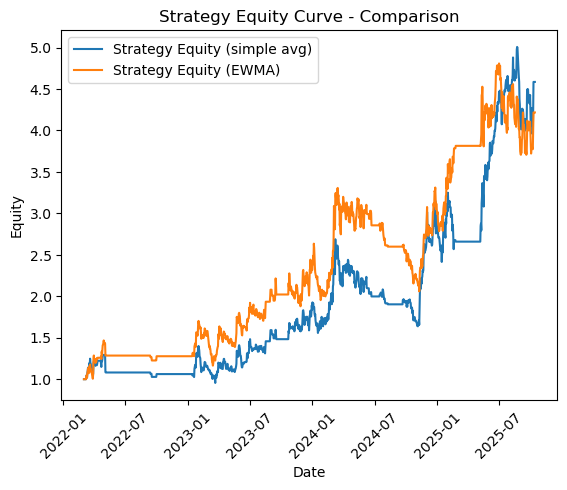

In [6]:
# Create equity series aligned to the rebalance start (index n) for both methods
equity_series_simple = pd.Series(equity_simple, index=price.index[n: n+len(equity_simple)])
equity_series_ewma = pd.Series(equity_ewma, index=price.index[n: n+len(equity_ewma)])

plt.plot(equity_series_simple, label="Strategy Equity (simple avg)")
plt.plot(equity_series_ewma, label="Strategy Equity (EWMA)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.title("Strategy Equity Curve - Comparison")
plt.xticks(rotation=45)
plt.legend()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_11252\2412518786.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  btc_cumret = btc_cumret.reindex(btc_idx).fillna(method='ffill').fillna(1.0)


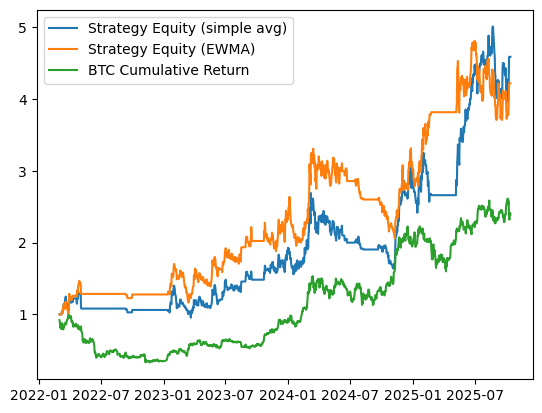

In [7]:
# Example: align equity with df index (ensure equity_series_simple/ewma defined and aligned to rebalance start)
equity_series_simple = pd.Series(equity_simple, index=price.index[n: n+len(equity_simple)])
equity_series_ewma = pd.Series(equity_ewma, index=price.index[n: n+len(equity_ewma)])
# BTC cumulative return - align to equity index (use the simple equity dates)
btc_cumret = (1 + price["BTCUSDT"].pct_change().fillna(0)).cumprod()
btc_idx = equity_series_simple.index
btc_cumret = btc_cumret.reindex(btc_idx).fillna(method='ffill').fillna(1.0)

plt.plot(equity_series_simple, label="Strategy Equity (simple avg)")
plt.plot(equity_series_ewma, label="Strategy Equity (EWMA)")
plt.plot(btc_cumret, label="BTC Cumulative Return")

plt.legend()
plt.show()